In [15]:
import requests
from bs4 import BeautifulSoup
import csv
from textblob import TextBlob
import pandas as pd

base_url = "https://www.airlinequality.com/airline-reviews/british-airways/page/"

def get_sentiment(text):
    """Returns sentiment: Positive, Negative, or Neutral"""
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity == 0:
        return "Neutral"
    else:
        return "Negative"

# Initialize CSV
with open('reviews.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Extend the CSV header with new columns
    writer.writerow(["Reviewer", "Review Date", "Score", "Review", "Sentiment","Sentiment score", "Type Of Traveller", 
                     "Seat Type", "Route", "Date Flown", "Seat Comfort", "Cabin Staff Service", 
                     "Food & Beverages", "Inflight Entertainment", "Ground Service", "Value For Money"])
    
    # Loop through all pages
    for i in range(1, 363):
        response = requests.get(base_url + str(i))
        
        if response.status_code != 200:
            print(f"Failed to retrieve page {i}")
            continue
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
     # ... [rest of your code remains unchanged]

        for review in soup.select('article[itemprop="review"]'):
            reviewer_elem = review.select_one('span[itemprop="name"]')
            reviewer = reviewer_elem.text if reviewer_elem else "N/A"

            date_elem = review.select_one('meta[itemprop="datePublished"]')
            date = date_elem['content'] if date_elem else "N/A"

            score_elem = review.select_one('span[itemprop="ratingValue"]')
            score = score_elem.text if score_elem else "N/A"

            review_content_elem = review.select_one('div[itemprop="reviewBody"]')
            review_content = review_content_elem.text.strip() if review_content_elem else "N/A"

            analysis = TextBlob(review_content)
            sentiment = get_sentiment(review_content)
            sentiment_score = analysis.sentiment.polarity

    # ... [rest of your code for extracting values remains unchanged]

            

            # Extract additional values
            def get_rating_value(css_selector):
                """Utility function to extract star ratings"""
                elements = review.select(css_selector + ' span.star.fill')
                return len(elements) if elements else "N/A"

            type_of_traveller_elem = review.select_one('.review-ratings tr td.review-rating-header.type_of_traveller + td.review-value')
            type_of_traveller = type_of_traveller_elem.text.strip() if type_of_traveller_elem else "N/A"
            
            seat_type_elem = review.select_one('.review-ratings tr td.review-rating-header.cabin_flown + td.review-value')
            seat_type = seat_type_elem.text.strip() if seat_type_elem else "N/A"
            
            route_elem = review.select_one('.review-ratings tr td.review-rating-header.route + td.review-value')
            route = route_elem.text.strip() if route_elem else "N/A"
            
            date_flown_elem = review.select_one('.review-ratings tr td.review-rating-header.date_flown + td.review-value')
            date_flown = date_flown_elem.text.strip() if date_flown_elem else "N/A"

            # Extract ratings for various categories
            seat_comfort = get_rating_value('.review-rating-header.seat_comfort + td.review-rating-stars')
            cabin_staff_service = get_rating_value('.review-rating-header.cabin_staff_service + td.review-rating-stars')
            food_beverages = get_rating_value('.review-rating-header.food_and_beverages + td.review-rating-stars')
            inflight_entertainment = get_rating_value('.review-rating-header.inflight_entertainment + td.review-rating-stars')
            ground_service = get_rating_value('.review-rating-header.ground_service + td.review-rating-stars')
            value_for_money = get_rating_value('.review-rating-header.value_for_money + td.review-rating-stars')

            writer.writerow([reviewer, date, score, review_content, sentiment,sentiment_score, type_of_traveller, seat_type, route, date_flown, 
                             seat_comfort, cabin_staff_service, food_beverages, inflight_entertainment, 
                             ground_service, value_for_money])
print("done")


done


In [4]:
df = pd.read_csv('reviews.csv')
df.head(20)
df.describe()
route_avg_scores = df.groupby('Route')['Score'].mean()
print(route_avg_scores.nsmallest(5))
print(route_avg_scores.nlargest(5))

Route
Amsterdam to Montreal via London    1.0
Antigua to London                   1.0
Athens to Boston via London         1.0
Austin to London via Dublin         1.0
Bangalore to Detroit via London     1.0
Name: Score, dtype: float64
Route
Belfast to San Francisco via London            10.0
Berlin to London City                          10.0
Boston to Dublin via London                    10.0
Buenos Aires to London                         10.0
Copenhagen to Amsterdam via London Heathrow    10.0
Name: Score, dtype: float64


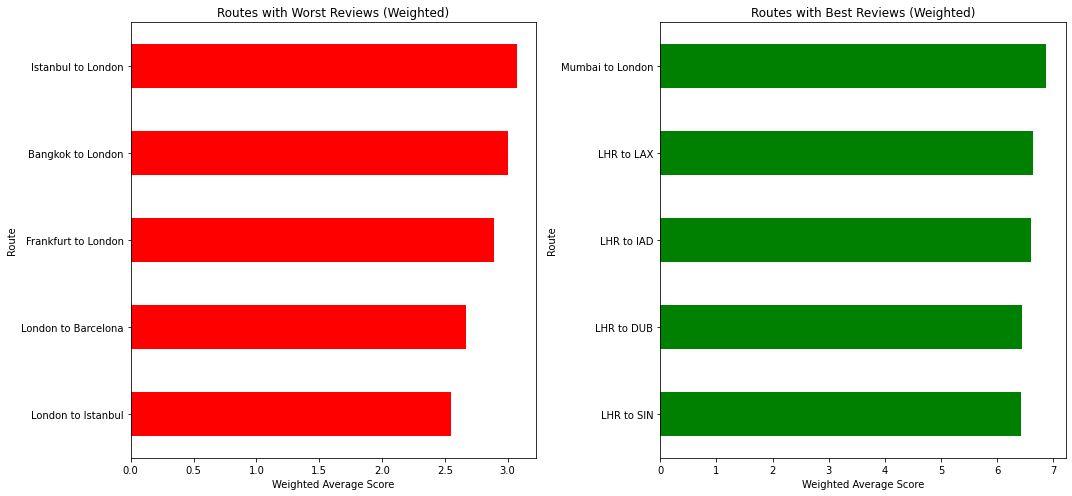

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data into a DataFrame
df = pd.read_csv('reviews.csv')

# Compute global mean and the number of reviews for each route
C = df['Score'].mean()
reviews_per_route = df.groupby('Route').size()
m = reviews_per_route.quantile(0.90)  # Set threshold as routes in the 90th percentile of review counts

# Filter routes that qualify for the chart, compute their Bayesian average
qualified_routes = df.groupby('Route').filter(lambda x: len(x) >= m)
grouped = qualified_routes.groupby('Route')
weighted_rating = grouped.apply(lambda x: (x['Score'].mean() * len(x) + C * m) / (len(x) + m)).sort_values()

# Plot
plt.figure(figsize=(15, 7))

# Worst reviews
plt.subplot(1, 2, 1)
weighted_rating.head(5).plot(kind='barh', color='red')
plt.title('Routes with Worst Reviews (Weighted)')
plt.xlabel('Weighted Average Score')

# Best reviews
plt.subplot(1, 2, 2)
weighted_rating.tail(5).plot(kind='barh', color='green')
plt.title('Routes with Best Reviews (Weighted)')
plt.xlabel('Weighted Average Score')

plt.tight_layout()
plt.show()


In [17]:
df = pd.read_csv('reviews.csv')

# Display some basic statistics
print(df.describe())

# Display the average score
print(f"Average score: {df['Score'].mean()}")

# Display sentiment distribution
print(df['Sentiment'].value_counts())


             Score  Sentiment score  Seat Comfort  Cabin Staff Service  \
count  3613.000000      3620.000000   3509.000000          3498.000000   
mean      4.754498         0.092384      2.880023             3.253859   
std       3.176832         0.180207      1.363359             1.492386   
min       1.000000        -0.766667      1.000000             1.000000   
25%       2.000000        -0.019792      2.000000             2.000000   
50%       4.000000         0.081316      3.000000             3.000000   
75%       8.000000         0.203517      4.000000             5.000000   
max      10.000000         0.800000      5.000000             5.000000   

       Food & Beverages  Inflight Entertainment  Ground Service  \
count       3243.000000             2502.000000     2802.000000   
mean           2.716312                2.645883        2.799429   
std            1.443893                1.403180        1.455183   
min            1.000000                1.000000        1.000000  

In [ ]:
#Average Score of reviews: 4.18/10
#Area with lowest average ratings

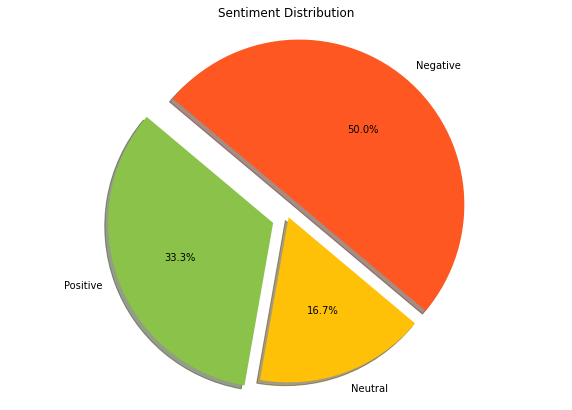

In [31]:
import matplotlib.pyplot as plt

# Sample data
labels = ['Positive', 'Neutral', 'Negative']
sizes = [5000, 2500, 7500]
colors = ['#8BC34A', '#FFC107', '#FF5722']  # Green for Positive, Yellow for Neutral, Red for Negative
explode = (0.1, 0, 0.1)  # explode 1st and 3rd slices for emphasis

# Plotting the pie chart
plt.figure(figsize=(10, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Sentiment Distribution")
plt.show()


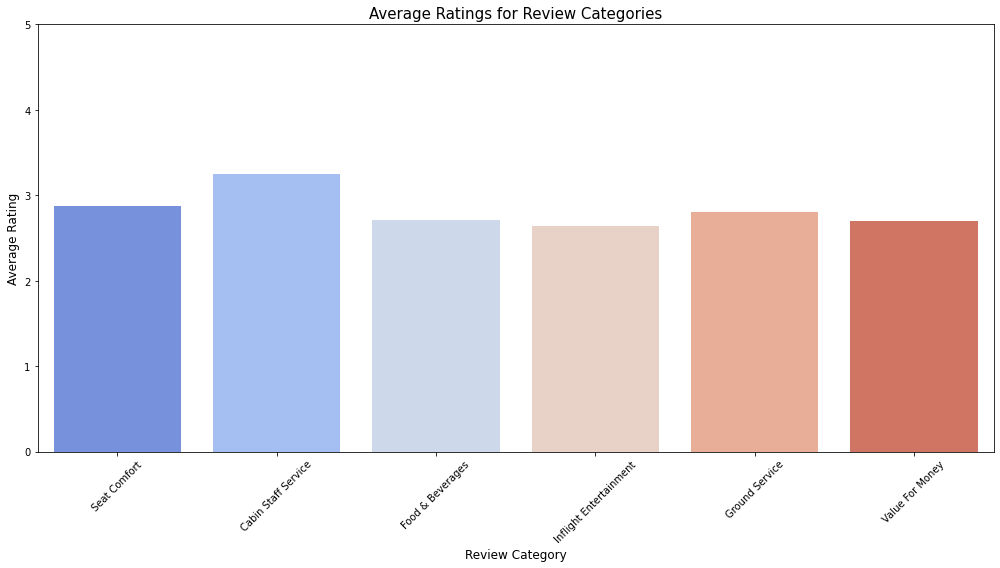

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('reviews.csv')

# Categories to consider
categories = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 
              'Inflight Entertainment', 'Ground Service', 'Value For Money']

# Calculate average ratings for each category
average_ratings = df[categories].mean()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x=average_ratings.index, y=average_ratings.values, palette="coolwarm")
plt.title('Average Ratings for Review Categories', fontsize=15)
plt.ylabel('Average Rating', fontsize=12)
plt.xlabel('Review Category', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 5)  # assuming the rating scale is from 0 to 5
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load your reviews dataset
df = pd.read_csv('reviews.csv')

# Filter reviews with negative sentiment
negative_reviews = df[df['Sentiment'] == 'Negative']['Review']

# Tokenize and perform frequency analysis
words = []
stop_words = set(stopwords.words('english'))

for review in negative_reviews:
    tokens = word_tokenize(review.lower())  # Convert to lowercase and tokenize
    words.extend([word for word in tokens if word.isalpha() and word not in stop_words])  # Remove non-words and stop words

word_freq = Counter(words)

# Let's say you want to view the top 20 keywords
common_issues = word_freq.most_common(100)

print(common_issues)




[('flight', 1812), ('ba', 1289), ('service', 733), ('verified', 705), ('british', 703), ('airways', 692), ('seat', 679), ('london', 670), ('food', 594), ('class', 576), ('seats', 572), ('business', 516), ('trip', 503), ('one', 481), ('staff', 477), ('cabin', 463), ('would', 457), ('time', 451), ('heathrow', 408), ('economy', 387), ('get', 383), ('crew', 378), ('hours', 373), ('airline', 368), ('could', 352), ('us', 351), ('even', 341), ('plane', 315), ('poor', 303), ('back', 303), ('return', 301), ('passengers', 294), ('customer', 292), ('told', 283), ('hour', 280), ('flights', 274), ('review', 265), ('experience', 242), ('check', 236), ('meal', 228), ('club', 227), ('boarding', 227), ('first', 226), ('airport', 223), ('airlines', 218), ('never', 216), ('another', 211), ('luggage', 211), ('delayed', 197), ('aircraft', 197), ('fly', 196), ('like', 194), ('premium', 193), ('worst', 189), ('offered', 187), ('due', 186), ('asked', 186), ('late', 184), ('people', 183), ('two', 183), ('minut

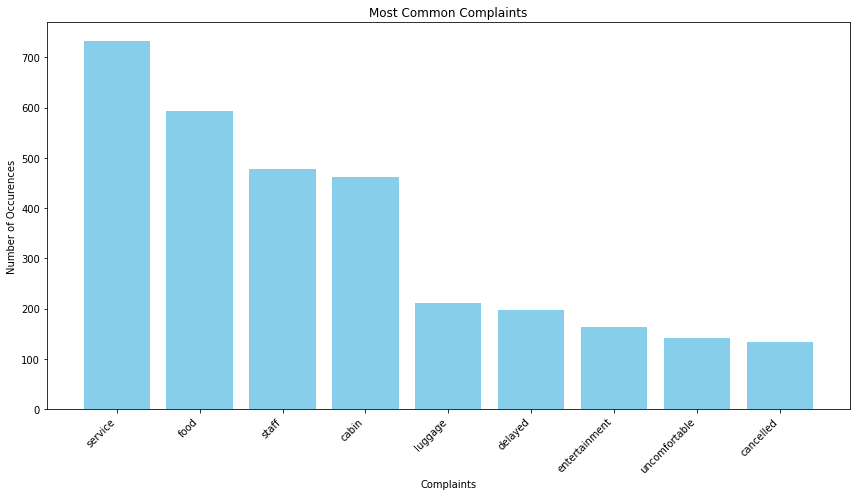

In [29]:
# Given list of word frequencies
word_frequencies = common_issues

# Whitelist: Only the words you are interested in
whitelist = ['service', 'food', 'staff', 'cabin',  'delayed', 'luggage', 'entertainment', 'uncomfortable',  'cancelled']

# Blacklist: Words you want to ignore
blacklist = ['flight', 'ba', 'british', 'airways', 'seat', 'london', 'class', 'trip', 'one', 'would', 'time', 'get', 'could', 'us', 'even', 'plane', 'return', 'review', 'check', 'first', 'never', 'like', 'way', 'old', 'next', 'good', 'go', 'day', 'world']

# Filtering using Whitelist
whitelist_filtered = [(word, freq) for word, freq in word_frequencies if word in whitelist]

# Filtering using Blacklist
blacklist_filtered = [(word, freq) for word, freq in word_frequencies if word not in blacklist]
whitelist_filtered = [(word, freq) for word, freq in word_frequencies if word in whitelist]

# Convert to DataFrame
df = pd.DataFrame(whitelist_filtered, columns=["Complaint", "Occurences"])

# Print the DataFrame with label

# Bar Chart
plt.figure(figsize=(12,7))
plt.bar(df["Complaint"], df["Occurences"], color='skyblue')
plt.title("Most Common Complaints")
plt.xlabel("Complaints")
plt.ylabel("Number of Occurences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

